# Denoising

In [121]:
# required imports
from keras.datasets   import mnist
from keras.layers     import Input, Dense
from keras.models     import Model
from keras.optimizers import SGD
from keras.utils      import np_utils

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import binomial
from numpy.random import standard_normal
import random

Al igual que en la sección 3.2, se crean los conjuntos de entrenamiento, validación y prueba.

In [122]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize intensity
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Transform into 
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Validation set
x_val = x_train[-5000:]
x_train = x_train[:-5000]
y_val = y_train[-5000:]
y_train = y_train[:-5000]

# Class vector to binary class matrix
y_train = np_utils.to_categorical(y_train, 10)
y_val = np_utils.to_categorical(y_val, 10)
y_test = np_utils.to_categorical(y_test, 10)

# A) Generación de masking noise

Se procede a generar una versión corrupta de los datos por medio del modelo *masking noise*. Se utilizará un ruido del 10%, esto es, sólo se utilizará un 10% de la información contenida en cada imágen para generar su versión corrupta.

In [46]:
def get_noise(noise_level, x_train, x_val, x_test):
    # Noise train values
    noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
    nx_train = x_train*noise_mask

    # Noise validation values
    noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
    nx_val = x_val*noise_mask

    # Noise test values
    noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
    nx_test = x_test*noise_mask
    
    return nx_train, nx_val, nx_test
    
noisy_x_train, noisy_x_val, noisy_x_test = get_noise(0.1, x_train, x_val, x_test)

Se visualizan algunas imágenes del conjunto de entrenamiento (segunda fila de imágenes) junto con su versión corrupta (primera fila de imágenes). Para el ojo humano, estas imágenes corruptas no son fáciles de distinguir.

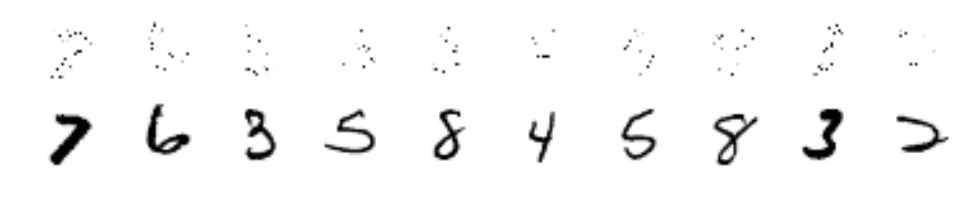

In [47]:
f, axarr = plt.subplots(2, 10,figsize=(12,2))
for i in range(10):
    random_int = random.randint(0, x_train.shape[0])
    axarr[0, i].imshow(noisy_x_train[random_int].reshape(28, 28), cmap='Greys')
    axarr[0, i].axis('off')
    axarr[1, i].imshow(x_train[random_int].reshape(28, 28), cmap='Greys')
    axarr[1, i].axis('off')
    
plt.show()


# B) Reconstrucción del dataser con masking noise

En esta sección, se desea reconstruir algunas de las imágenes corruptas que se generaron en la sección anterior, pertenecientes al conjunto de pruebas. Para determinar la calidad de la reconstrucción, se determinará el error de reconstrucción para cada una de ellas. El proceso de reconstrucción es llevado a cabo a partir de un autoencoder, el que es implementado en el siguiente código. Se estudian los resultados obtenidos para diferentes valores de p, con p = 0; 0,125; 0,25; 0,375; 0,5; 0,625; 0,75; 0,875; 1.

p = 0.0
Error de Reconstrucción: 0.262516171217


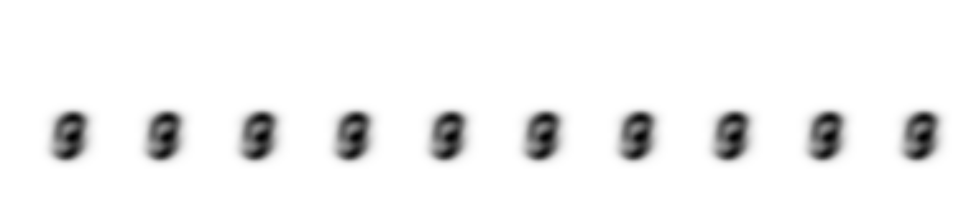

p = 0.125
Error de Reconstrucción: 0.206172488379


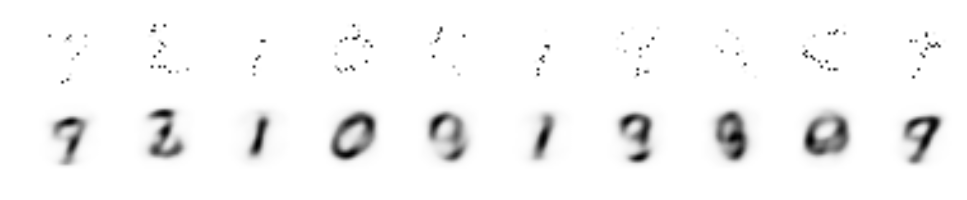

p = 0.25
Error de Reconstrucción: 0.18775670321


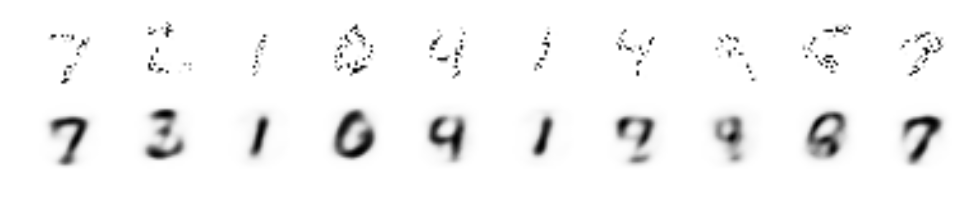

p = 0.375
Error de Reconstrucción: 0.180132495451


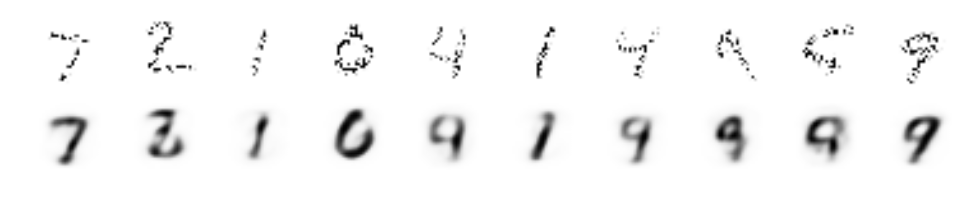

p = 0.5
Error de Reconstrucción: 0.179319118595


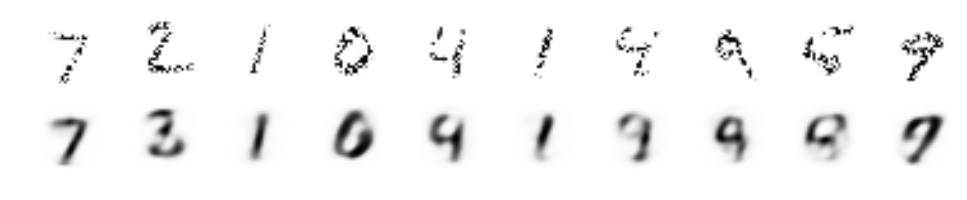

p = 0.625
Error de Reconstrucción: 0.171800758266


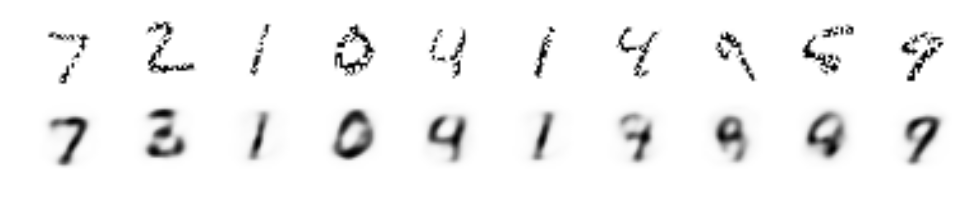

p = 0.75
Error de Reconstrucción: 0.181030570722


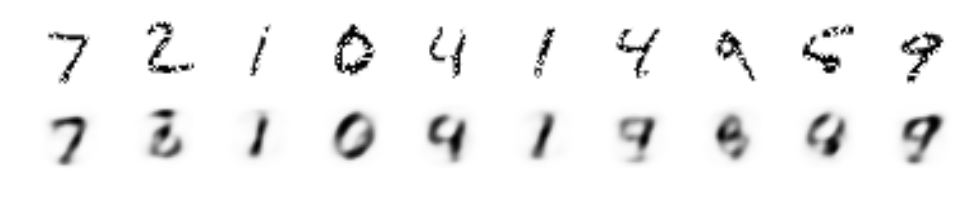

p = 0.875
Error de Reconstrucción: 0.182125979924


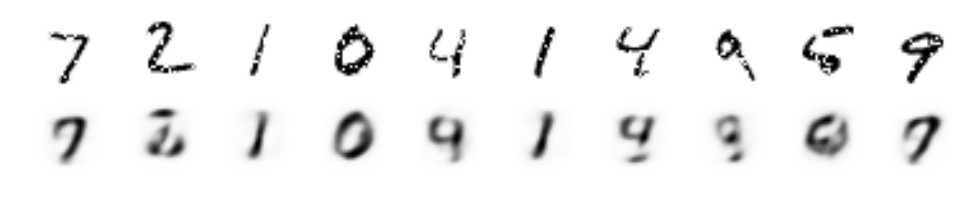

p = 1.0
Error de Reconstrucción: 0.178272849274


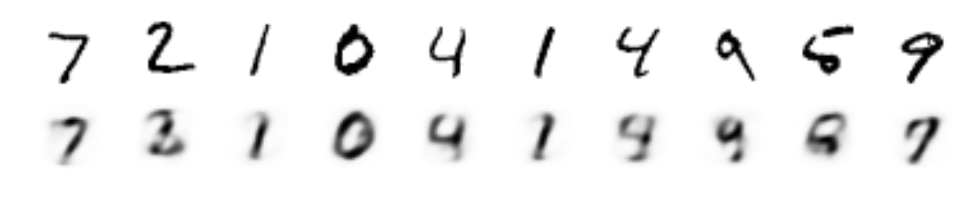

In [79]:
for n_lvl in np.linspace(0, 1, num=9):
    noisy_x_train, noisy_x_val, noisy_x_test = get_noise(n_lvl, x_train, x_val, x_test)
    
    # AE
    input_img = Input(shape=(784,))
    encoded = Dense(32, activation='sigmoid')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(inputs=input_img, outputs=decoded)
    encoder = Model(inputs=input_img, outputs=encoded)
    encoded_input = Input(shape=(32,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder.fit(noisy_x_train, x_train, epochs=50, batch_size=25, shuffle=True, 
                    validation_data=(noisy_x_val, x_val), verbose=0)
    
    encoded_test = encoder.predict(noisy_x_test)
    decoded_test = decoder.predict(encoded_test)
    
    error_rebuild = autoencoder.evaluate(noisy_x_test, x_test, verbose=0)
    
    print('p = ' + str(n_lvl))
    print('Error de Reconstrucción: ' + str(error_rebuild))
    
    f, axarr = plt.subplots(2, 10,figsize=(12,2))
    for i in range(10):
        axarr[0, i].imshow(noisy_x_test[i].reshape(28, 28), cmap='Greys')
        axarr[0, i].axis('off')
        axarr[1, i].imshow(decoded_test[i].reshape(28, 28), cmap='Greys')
        axarr[1, i].axis('off')

    plt.show()

Los resultados muestran que el error de reconstrucción disminuye entre p = 0 y p = 0,625, luego aumenta levemente entre p = 0,75 y p = 0,875, para finalmente disminuir en p = 1. El error mínimo es del 17,2%, para p = 0,625, mientras que el error máximo es del 26,3% para p = 0. Esta situación es consistente con la percepción visual de las reconstrucciones, pues para p = 0, todos los dígitos reconstruídos son idénticos, lo que claramente no debiese ocurrir, mientras que para p = 0,625 se puede observar que las reconstrucciones son muy similares a los dígitos originales. 

# C) Gaussian noise


Se procede a generar una versión corrupta para cada uno de los conjuntos de datos originales, pero utilizando ahora el modelo *Gaussian noise*.

In [123]:
def get_noise_gaussian(devst, x_train, x_val, x_test):
    noise_mask = devst*standard_normal(size=x_train.shape)
    nx_train = x_train + noise_mask
    noise_mask = devst*standard_normal(size=x_val.shape)
    nx_val = x_val + noise_mask
    noise_mask = devst*standard_normal(size=x_test.shape)
    nx_test = x_test + noise_mask
    
    return nx_train, nx_val, nx_test
    
noisy_x_train, noisy_x_val, noisy_x_test = get_noise_gaussian(0.5, x_train, x_val, x_test)

Añadido el ruido a cada conjunto de imágenes, se muestran algunas de las imágenes corruptas (primera fila de imágenes) junto con sus versiones originales (segunda fila de imágenes). Gracias a esta visualización, es posible apreciar como las imágenes corruptas son muy diferentes a las generadas con el modelo anterior, en el sentido de que aquí se ha distorsionado no sólo el dígito, si no también los píxeles circundantes.

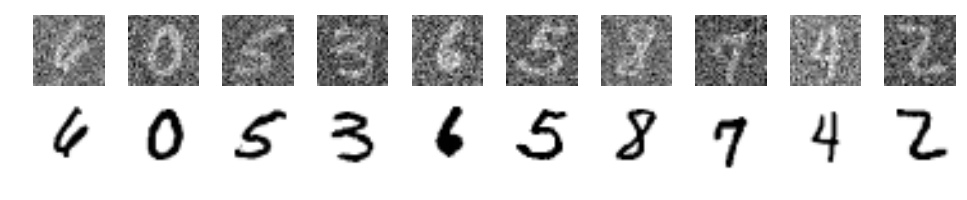

In [124]:
f, axarr = plt.subplots(2, 10,figsize=(12,2))
for i in range(10):
    random_int = random.randint(0, x_train.shape[0])
    axarr[0, i].imshow(noisy_x_train[random_int].reshape(28, 28))
    axarr[0, i].axis('off')
    axarr[1, i].imshow(x_train[random_int].reshape(28, 28), cmap='Greys')
    axarr[1, i].axis('off')
    
plt.show()

# D) Reconstrucción del dataser con Gaussian noise

De forma análoga a la sección B), se reconstruyen algunas imágenes generadas con el modelo gaussiano del conjunto de pruebas y se determina el error de reconstrucción respectivo. Se estudian diferentes valores para el parámetro sigma (devst), con sigma = 0; 0,125; 0,25; 0,375; 0,5; 0,625; 0,75; 0,875; 1.

**FE DE ERRATAS: En la parte que se muestran las imágenes, debiese decir sigma, en vez de p.**

p = 0.0
Error de reconstrucción: 0.0932285409927


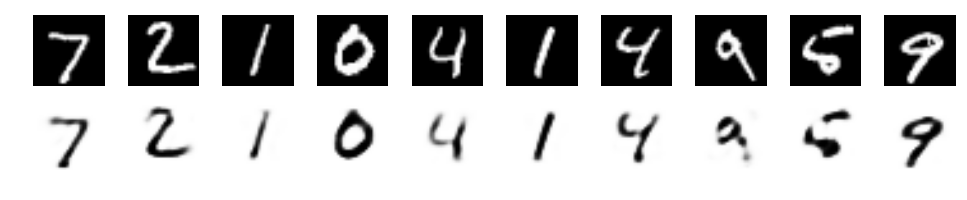

p = 0.125
Error de reconstrucción: 0.0952120179296


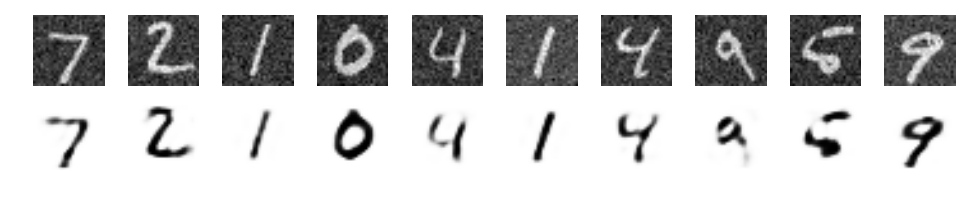

p = 0.25
Error de reconstrucción: 0.102786097717


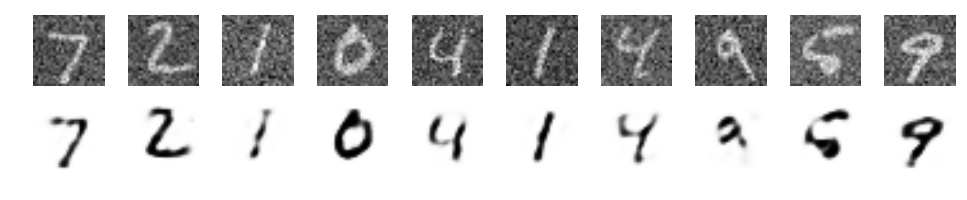

p = 0.375
Error de reconstrucción: 0.112382944322


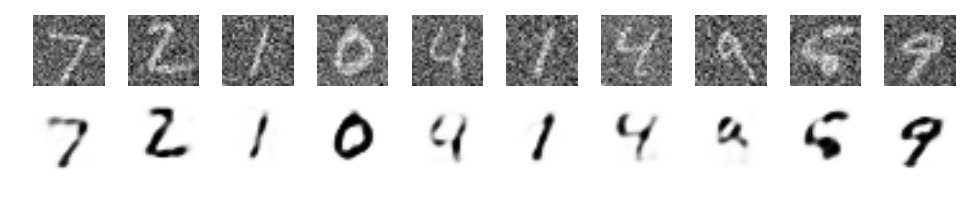

p = 0.5
Error de reconstrucción: 0.123178024769


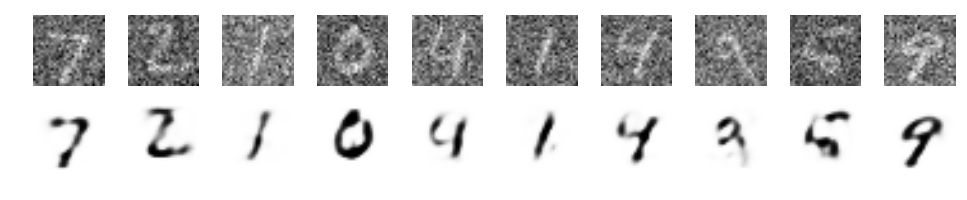

p = 0.625
Error de reconstrucción: 0.134044146752


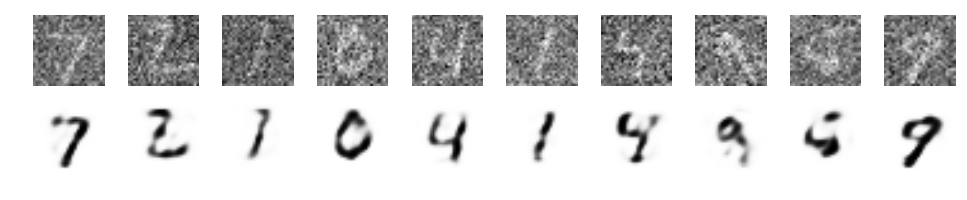

p = 0.75
Error de reconstrucción: 0.143439893246


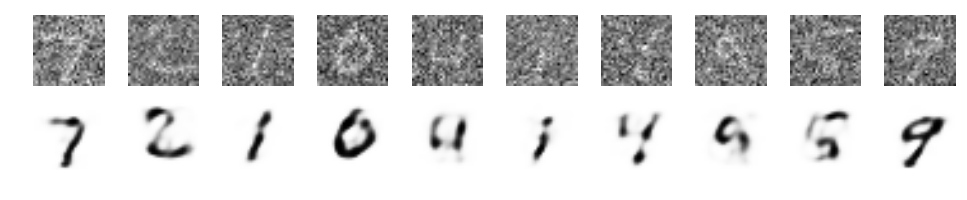

p = 0.875
Error de reconstrucción: 0.152461021829


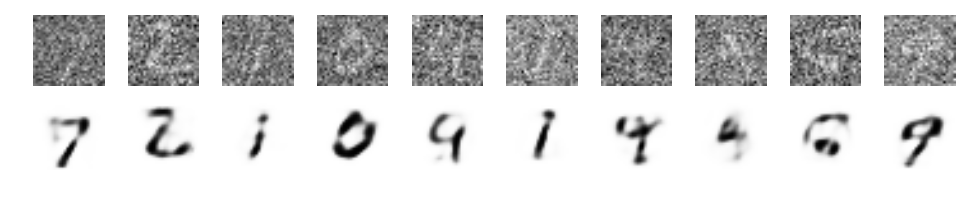

p = 1.0
Error de reconstrucción: 0.160940292597


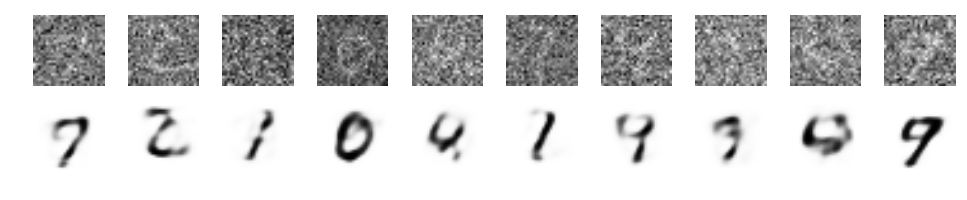

In [125]:
for n_lvl in np.linspace(0, 1, num=9):
    noisy_x_train, noisy_x_val, noisy_x_test = get_noise_gaussian(n_lvl, x_train, x_val, x_test)
    
    # AE
    input_img = Input(shape=(784,))
    encoded = Dense(32, activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(inputs=input_img, outputs=decoded)
    encoder = Model(inputs=input_img, outputs=encoded)
    encoded_input = Input(shape=(32,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder.fit(noisy_x_train, x_train, epochs=50, batch_size=25, shuffle=True, 
                    validation_data=(noisy_x_val, x_val), verbose=0)
    
    encoded_test = encoder.predict(noisy_x_test)
    decoded_test = decoder.predict(encoded_test)
    
    error_rebuild = autoencoder.evaluate(noisy_x_test, x_test, verbose=0)
    
    print('p = ' + str(n_lvl))
    print(u'Error de reconstrucción: ' + str(error_rebuild))
    
    f, axarr = plt.subplots(2, 10,figsize=(12,2))
    for i in range(10):
        axarr[0, i].imshow(noisy_x_test[i].reshape(28, 28))
        axarr[0, i].axis('off')
        plt.gray()
        axarr[1, i].imshow(decoded_test[i].reshape(28, 28), cmap='Greys')
        axarr[1, i].axis('off')
        

    plt.show()

Es posible ver como el error de reconstrucción aumenta a medida que también lo hace el valor de sigma, de tal forma que el error alcanza su valor mínimo de 9,5% para sigma = 0,125 (no se considera sigma = 0, pues corresponde al caso trivial de no agregar ruido), mientras que el valor máximo es de 16,1% para sigma = 1. Esta situación es consistente con la percepción visual de las reconstrucciones, pues mientras mayor es el valor de sigma, más difícil es distinguir el dígito reconstruído.

Notar que el error de reconstrucción mínimo obtenido para *Gaussian noise* es menor que el error de reconstrucción mínimo conseguido con *masked noise*.

# E) Reducción de dimensionalidad

Finalmente, se estudiará el proceso de llevar a cabo reducción de dimensionalidad en las imágenes tal y como se hizo en la sección 3.1, pero esta vez, dicha reducción se realizará a partir de las imágenes corruptas generadas con el modelo *masking noise*. Como el error de reconstrucción más bajo se obtuvo con p = 0,625, se estudiarán las imágenes corruptas generadas con este valor.

Primero, se "corrompe" cada conjunto de datos.

In [ ]:
noisy_x_train, noisy_x_val, noisy_x_test = get_noise(0.625, x_train, x_val, x_test)

Luego, se estudia el error de reconstrucción y de clasificación sobre el conjunto de pruebas para distintas compresiones d', con d' = 2, 4, 8, 16, 32. Para la clasificación, se utilizará kNN con k = 10.

In [ ]:
for d_ in [2, 4, 8, 16, 32]:
    input_img = Input(shape=(784,))
    # "encoded" es la versión codificada del input
    encoded = Dense(d_, activation='relu')(input_img)
    # "decoded" es la reconstrucción del input codificado
    decoded = Dense(784, activation='sigmoid')(encoded)
    # Se genera AE a partir de capas anteriores, el cual mapea un input hacia su reconstrucción
    autoencoder = Model(input=input_img, output=decoded)
    # Se definen método de entrenamiento y función de pérdida
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    # Se entrena AE
    history = autoencoder.fit(noisy_x_train, noisy_x_train,
              epochs=50,
              batch_size=256,
              shuffle=True,
              verbose=0,
              validation_data=(noisy_x_val, noisy_x_val))
    
    # Se determina error de reconstrucción
    error_rebuild = autoencoder.evaluate(noisy_x_test, x_test, verbose=0)
    
    # Se determina error de clasificación
    # Se implementa encoder por separado
    encoded = Dense(d_, activation='relu')(input_img)
    encoder = Model(input_img, output=encoded)
    encoded_noisy_train = encoder.predict(noisy_x_train)
    encoded_noisy_test = encoder.predict(noisy_x_test)
    # Se crea clasificador kNN, con k = 10
    clf = KNeighborsClassifier(10)
    # Se entrena clasificador
    clf.fit(encoded_noisy_train, y_train)
    # Se determina error de clasificación
    classification_error = clf.score(encoded_noisy_test, y_test)
    
    print 'Compresion: ' + str(d_)
    print 'Error de reconstruccion sobre conjunto de pruebas: ' + str(error_rebuild)
    print 'Error de clasificacion sobre conjunto de pruebas: ' + str(classification_error * 100) + '%'
    print '/n'